In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, random_split, DataLoader
import numpy as np
import torch.nn.functional as F
from PIL import Image

In [2]:
import torchvision
from torchvision import datasets
from torchvision import datasets, transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)) # (mean,), (std,)
])
train_data =datasets.MNIST(root="data",train=True,download=True,transform=torchvision.transforms.ToTensor())
train_data,val_data=random_split(train_data,[50000,10000])
test_data =datasets.MNIST(root="data",train=False,download=True,transform=torchvision.transforms.ToTensor())

100%|██████████| 9.91M/9.91M [00:01<00:00, 4.98MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 130kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.24MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.59MB/s]


In [3]:
device="cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [4]:
BATCH_SIZE = 64
train_loader= torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader= torch.utils.data.DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)
test_loader= torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

In [5]:
input_size=28
sequence_length=28
num_layers=2
hidden_size=128
num_classes=10
num_epochs=15
batch_size=64
lr=1e-3

In [6]:
class RNN(nn.Module):
  def __init__(self,input_size,hidden_size,num_layers,num_classes,rnn_type,bidirectional=False):
    super().__init__()
    self.hidden_size=hidden_size
    self.num_layers=num_layers
    self.rnn_type=rnn_type
    self.bidirectional=bidirectional
    if rnn_type=="LSTM":
      self.rnn=nn.LSTM(input_size,hidden_size,num_layers,batch_first=True,bidirectional=bidirectional)
    elif rnn_type=="GRU":
      self.rnn=nn.GRU(input_size,hidden_size,num_layers,batch_first=True,bidirectional=bidirectional)
    else:
      self.rnn=nn.RNN(input_size,hidden_size,num_layers,batch_first=True,bidirectional=bidirectional)
    fc_input=hidden_size*2 if bidirectional else hidden_size
    #x -> [batch,seq,input_size]
    self.fc=nn.Linear(fc_input,num_classes)


  def forward(self,x):
    num_directions=2 if self.bidirectional else 1
    h0=torch.zeros(self.num_layers*num_directions,x.size(0),self.hidden_size).to(device)
    if self.rnn_type=="LSTM":
      c0=torch.zeros(self.num_layers*num_directions,x.size(0),self.hidden_size).to(device)
      out,_=self.rnn(x,(h0,c0))
    else:
      out,_=self.rnn(x,h0)
    #out:n,seq,hidden_size
    out=out[:,-1,:]
    #out(n,128)
    out=out.reshape(out.shape[0],-1)
    out=self.fc(out)
    return out



In [7]:
def train(model,epochs,train_loader,val_loader,optimizer,criterion):
  train_loss=[]
  val_loss=[]
  val_acc=[]
  test_acc=[]
  for epoch in range(epochs):
    model.train()
    runn_train_loss=0
    for data in train_loader:
      img,label=data
      img=torch.reshape(img,(img.shape[0],28,28))
      img=img.to(device)
      label=label.to(device)
      optimizer.zero_grad()
      output=model(img)
      loss=criterion(output,label)
      loss.backward()
      optimizer.step()
      runn_train_loss+=loss.item()
    train_loss.append(runn_train_loss/len(train_loader))
    with torch.no_grad():
      model.eval()
      runn_val_loss=0
      n_correct=0
      n_samples=0
      n_t_correct=0
      n_t_samples=0
      for val_data in val_loader:
        img,label=val_data
        img=torch.reshape(img,(img.shape[0],28,28))
        img=img.to(device)
        label=label.to(device)
        output=model(img)
        predicted=torch.argmax(output,1)
        n_correct+=(predicted==label).sum().item()
        n_samples+=label.size(0)
        loss=criterion(output,label)
        runn_val_loss+=loss.item()
      val_loss.append(runn_val_loss/len(val_loader))
      val_acc.append(n_correct/n_samples)
      for test_data in test_loader:
        img,label=test_data
        img=torch.reshape(img,(img.shape[0],28,28))
        img=img.to(device)
        label=label.to(device)
        output=model(img)
        predicted=torch.argmax(output,1)
        n_t_correct+=(predicted==label).sum().item()
        n_t_samples+=label.size(0)
      test_acc.append(n_t_correct/n_t_samples)
    print (f'Epoch [{epoch+1}/{epochs}], train_loss: {train_loss[-1]:.4f} , val_loss: {val_loss[-1]:.4f} , val_acc: {val_acc[-1]:.4f} , test_acc: {test_acc[-1]:.4f}')

  return train_loss,val_loss,val_acc,test_acc


In [8]:
def plot_image(model):
  model.eval()
  plt.figure(figsize=(15, 4))
  random_test=np.random.randint(0,10000,(10,))
  index=0
  with torch.no_grad():
    for i in random_test:
      original_img=test_data[i][0].reshape(28,28)
      ax=plt.subplot(2,len(random_test),index+1)
      model_img=test_data[i][0].reshape(1,28,28).to(device)
      label=test_data[i][1]
      predicted=model(model_img)
      predicted=torch.argmax(predicted,1).to("cpu").item()
      plt.imshow(original_img,cmap="gray")
      ax.set_title(f"actual:{label}|prediction:{predicted}",size=8)
      ax.axis("off")
      index+=1

1. VANILLA RNN

In [12]:
criterion=nn.CrossEntropyLoss()

In [ ]:
vanilla_rnn=RNN(input_size,hidden_size,num_layers,num_classes,"RNN").to(device)

In [ ]:
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(vanilla_rnn.parameters(),lr=1e-3)
train_loss,val_loss,val_acc,test_acc=train(vanilla_rnn,num_epochs,train_loader,val_loader,optimizer,criterion)

Epoch [1/15], train_loss: 0.2203 , val_loss: 0.2829 , val_acc: 0.9147 , test_acc: 0.9176
Epoch [2/15], train_loss: 0.1716 , val_loss: 0.1469 , val_acc: 0.9579 , test_acc: 0.9579
Epoch [3/15], train_loss: 0.1497 , val_loss: 0.1402 , val_acc: 0.9583 , test_acc: 0.9646
Epoch [4/15], train_loss: 0.1398 , val_loss: 0.1914 , val_acc: 0.9405 , test_acc: 0.9485
Epoch [5/15], train_loss: 0.1187 , val_loss: 0.1203 , val_acc: 0.9643 , test_acc: 0.9666
Epoch [6/15], train_loss: 0.1248 , val_loss: 0.1170 , val_acc: 0.9669 , test_acc: 0.9678
Epoch [7/15], train_loss: 0.1181 , val_loss: 0.1329 , val_acc: 0.9624 , test_acc: 0.9640
Epoch [8/15], train_loss: 0.1139 , val_loss: 0.1178 , val_acc: 0.9659 , test_acc: 0.9672
Epoch [9/15], train_loss: 0.1104 , val_loss: 0.1418 , val_acc: 0.9595 , test_acc: 0.9646
Epoch [10/15], train_loss: 0.1017 , val_loss: 0.1120 , val_acc: 0.9691 , test_acc: 0.9729
Epoch [11/15], train_loss: 0.0997 , val_loss: 0.1134 , val_acc: 0.9666 , test_acc: 0.9732
Epoch [12/15], trai

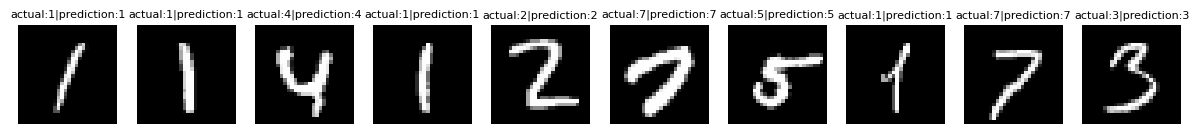

In [ ]:
plot_image(vanilla_rnn)

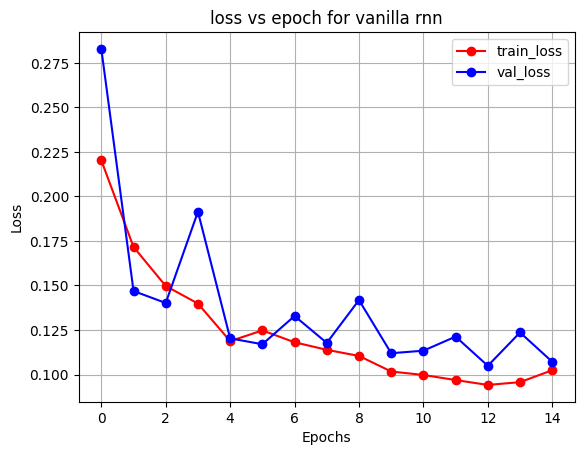

In [ ]:
plt.plot(range(15),train_loss,c="r",marker="o",label="train_loss")
plt.plot(range(15),val_loss,c="b",marker="o",label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("loss vs epoch for vanilla rnn")
plt.grid(True)
plt.legend()
plt.show()

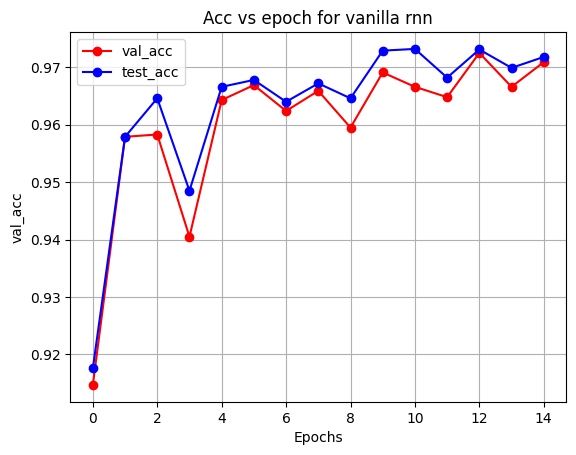

In [ ]:
plt.plot(range(15),val_acc,c="r",marker="o",label="val_acc")
plt.plot(range(15),test_acc,c="b",marker="o",label="test_acc")
plt.xlabel("Epochs")
plt.ylabel("val_acc")
plt.title("Acc vs epoch for vanilla rnn")
plt.grid(True)
plt.legend()
plt.show()

2. LSTM

In [ ]:
lstm=RNN(input_size,hidden_size,num_layers,num_classes,"LSTM").to(device)
optimizer=torch.optim.Adam(lstm.parameters(),lr=1e-3)
train_loss,val_loss,val_acc,test_acc=train(lstm,num_epochs,train_loader,val_loader,optimizer,criterion)

Epoch [1/15], train_loss: 0.5106 , val_loss: 0.1856 , val_acc: 0.9440 , test_acc: 0.9532
Epoch [2/15], train_loss: 0.1231 , val_loss: 0.0982 , val_acc: 0.9686 , test_acc: 0.9722
Epoch [3/15], train_loss: 0.0792 , val_loss: 0.0740 , val_acc: 0.9768 , test_acc: 0.9781
Epoch [4/15], train_loss: 0.0631 , val_loss: 0.0621 , val_acc: 0.9818 , test_acc: 0.9807
Epoch [5/15], train_loss: 0.0507 , val_loss: 0.0635 , val_acc: 0.9809 , test_acc: 0.9808
Epoch [6/15], train_loss: 0.0411 , val_loss: 0.0552 , val_acc: 0.9838 , test_acc: 0.9826
Epoch [7/15], train_loss: 0.0371 , val_loss: 0.0557 , val_acc: 0.9834 , test_acc: 0.9830
Epoch [8/15], train_loss: 0.0325 , val_loss: 0.0448 , val_acc: 0.9865 , test_acc: 0.9869
Epoch [9/15], train_loss: 0.0273 , val_loss: 0.0452 , val_acc: 0.9882 , test_acc: 0.9880
Epoch [10/15], train_loss: 0.0275 , val_loss: 0.0538 , val_acc: 0.9838 , test_acc: 0.9845
Epoch [11/15], train_loss: 0.0243 , val_loss: 0.0476 , val_acc: 0.9855 , test_acc: 0.9869
Epoch [12/15], trai

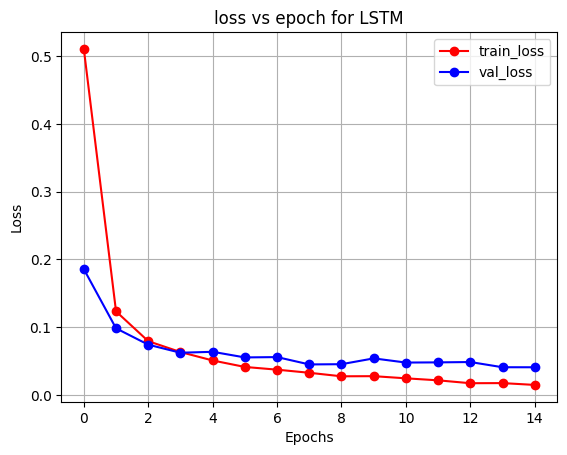

In [ ]:
plt.plot(range(15),train_loss,c="r",marker="o",label="train_loss")
plt.plot(range(15),val_loss,c="b",marker="o",label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("loss vs epoch for LSTM")
plt.grid(True)
plt.legend()
plt.show()

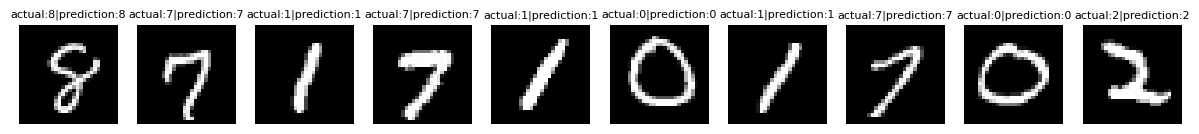

In [ ]:
plot_image(lstm)

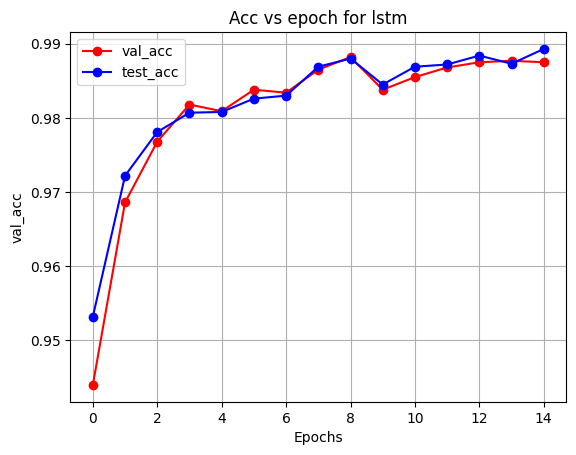

In [ ]:
plt.plot(range(15),val_acc,c="r",marker="o",label="val_acc")
plt.plot(range(15),test_acc,c="b",marker="o",label="test_acc")
plt.xlabel("Epochs")
plt.ylabel("val_acc")
plt.title("Acc vs epoch for lstm")
plt.grid(True)
plt.legend()
plt.show()

3. GRU

In [ ]:
gru=RNN(input_size,hidden_size,num_layers,num_classes,"GRU").to(device)
optimizer=torch.optim.Adam(gru.parameters(),lr=1e-3)
train_loss,val_loss,val_acc,test_acc=train(gru,num_epochs,train_loader,val_loader,optimizer,criterion)

Epoch [1/15], train_loss: 0.4500 , val_loss: 0.1485 , val_acc: 0.9551 , test_acc: 0.9593
Epoch [2/15], train_loss: 0.1083 , val_loss: 0.0938 , val_acc: 0.9698 , test_acc: 0.9720
Epoch [3/15], train_loss: 0.0670 , val_loss: 0.0621 , val_acc: 0.9811 , test_acc: 0.9828
Epoch [4/15], train_loss: 0.0505 , val_loss: 0.0546 , val_acc: 0.9835 , test_acc: 0.9852
Epoch [5/15], train_loss: 0.0392 , val_loss: 0.0645 , val_acc: 0.9810 , test_acc: 0.9846
Epoch [6/15], train_loss: 0.0350 , val_loss: 0.0525 , val_acc: 0.9844 , test_acc: 0.9870
Epoch [7/15], train_loss: 0.0279 , val_loss: 0.0481 , val_acc: 0.9864 , test_acc: 0.9857
Epoch [8/15], train_loss: 0.0253 , val_loss: 0.0564 , val_acc: 0.9849 , test_acc: 0.9854
Epoch [9/15], train_loss: 0.0205 , val_loss: 0.0480 , val_acc: 0.9867 , test_acc: 0.9886
Epoch [10/15], train_loss: 0.0197 , val_loss: 0.0441 , val_acc: 0.9865 , test_acc: 0.9892
Epoch [11/15], train_loss: 0.0173 , val_loss: 0.0554 , val_acc: 0.9855 , test_acc: 0.9850
Epoch [12/15], trai

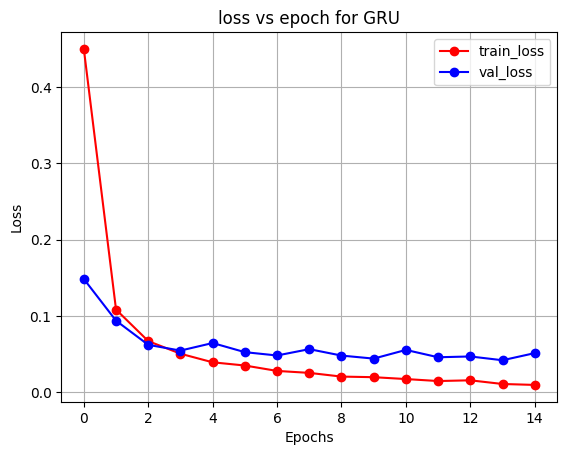

In [ ]:
plt.plot(range(15),train_loss,c="r",marker="o",label="train_loss")
plt.plot(range(15),val_loss,c="b",marker="o",label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("loss vs epoch for GRU")
plt.grid(True)
plt.legend()
plt.show()

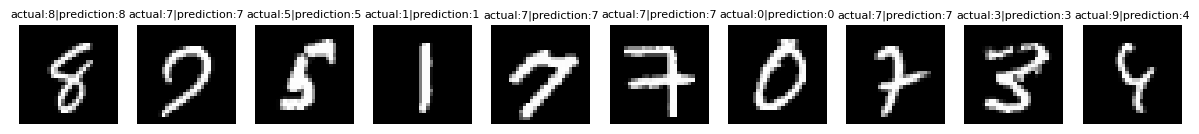

In [ ]:
plot_image(gru)

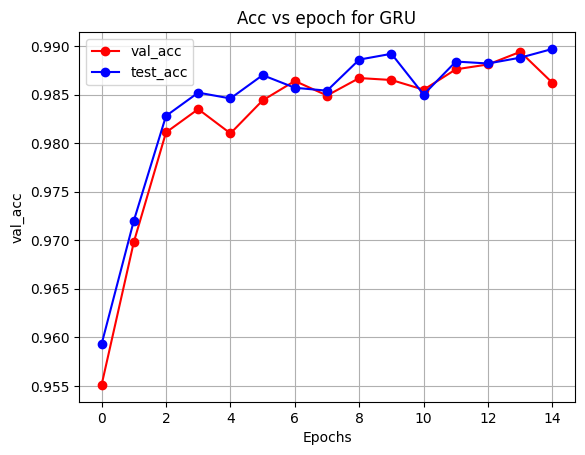

In [ ]:
plt.plot(range(15),val_acc,c="r",marker="o",label="val_acc")
plt.plot(range(15),test_acc,c="b",marker="o",label="test_acc")
plt.xlabel("Epochs")
plt.ylabel("val_acc")
plt.title("Acc vs epoch for GRU")
plt.grid(True)
plt.legend()
plt.show()

4. BIDIRECTIONAL RNN

In [ ]:
vanilla_rnn_bi=RNN(input_size,hidden_size,num_layers,num_classes,"RNN",bidirectional=True).to(device)
optimizer=torch.optim.Adam(vanilla_rnn_bi.parameters(),lr=1e-3)
train_loss,val_loss,val_acc,test_acc=train(vanilla_rnn_bi,num_epochs,train_loader,val_loader,optimizer,criterion)

Epoch [1/15], train_loss: 0.6613 , val_loss: 0.3964 , val_acc: 0.8726 , test_acc: 0.8768
Epoch [2/15], train_loss: 0.2785 , val_loss: 0.2328 , val_acc: 0.9344 , test_acc: 0.9370
Epoch [3/15], train_loss: 0.2064 , val_loss: 0.1736 , val_acc: 0.9498 , test_acc: 0.9532
Epoch [4/15], train_loss: 0.1742 , val_loss: 0.2096 , val_acc: 0.9385 , test_acc: 0.9448
Epoch [5/15], train_loss: 0.1571 , val_loss: 0.1539 , val_acc: 0.9570 , test_acc: 0.9598
Epoch [6/15], train_loss: 0.1325 , val_loss: 0.1575 , val_acc: 0.9562 , test_acc: 0.9611
Epoch [7/15], train_loss: 0.1333 , val_loss: 0.2261 , val_acc: 0.9315 , test_acc: 0.9342
Epoch [8/15], train_loss: 0.1345 , val_loss: 0.1315 , val_acc: 0.9626 , test_acc: 0.9648
Epoch [9/15], train_loss: 0.1180 , val_loss: 0.1233 , val_acc: 0.9647 , test_acc: 0.9686
Epoch [10/15], train_loss: 0.1043 , val_loss: 0.1249 , val_acc: 0.9659 , test_acc: 0.9679
Epoch [11/15], train_loss: 0.1134 , val_loss: 0.1335 , val_acc: 0.9619 , test_acc: 0.9639
Epoch [12/15], trai

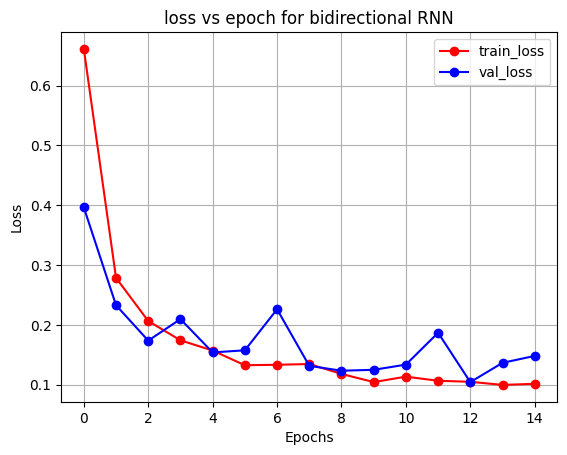

In [ ]:
plt.plot(range(15),train_loss,c="r",marker="o",label="train_loss")
plt.plot(range(15),val_loss,c="b",marker="o",label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("loss vs epoch for bidirectional RNN")
plt.grid(True)
plt.legend()
plt.show()

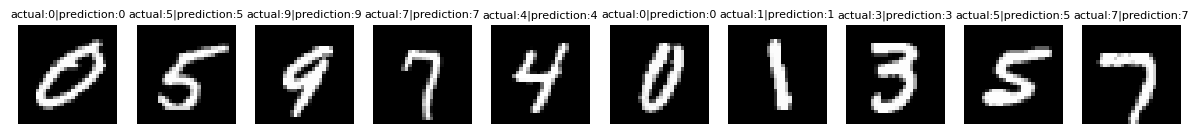

In [ ]:
plot_image(vanilla_rnn_bi)

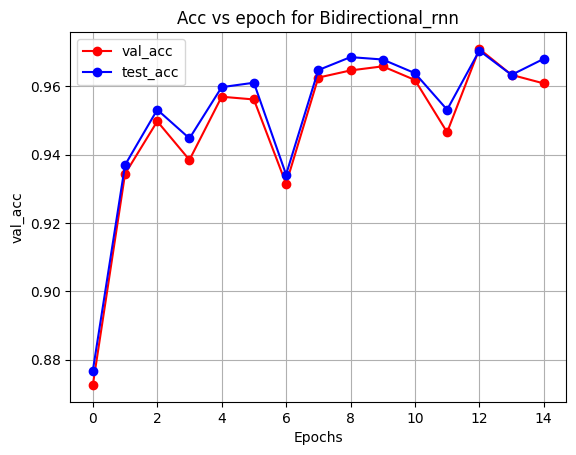

In [ ]:
plt.plot(range(15),val_acc,c="r",marker="o",label="val_acc")
plt.plot(range(15),test_acc,c="b",marker="o",label="test_acc")
plt.xlabel("Epochs")
plt.ylabel("val_acc")
plt.title("Acc vs epoch for Bidirectional_rnn")
plt.grid(True)
plt.legend()
plt.show()

5. BIDIRECTIONAL LSTM

In [ ]:
lstm_bi=RNN(input_size,hidden_size,num_layers,num_classes,"LSTM",bidirectional=True).to(device)
optimizer=torch.optim.Adam(lstm_bi.parameters(),lr=1e-3)
train_loss,val_loss,val_acc,test_acc=train(lstm_bi,num_epochs,train_loader,val_loader,optimizer,criterion)

Epoch [1/15], train_loss: 0.5160 , val_loss: 0.2271 , val_acc: 0.9341 , test_acc: 0.9410
Epoch [2/15], train_loss: 0.1365 , val_loss: 0.1128 , val_acc: 0.9663 , test_acc: 0.9687
Epoch [3/15], train_loss: 0.0978 , val_loss: 0.1114 , val_acc: 0.9656 , test_acc: 0.9677
Epoch [4/15], train_loss: 0.0727 , val_loss: 0.0811 , val_acc: 0.9757 , test_acc: 0.9763
Epoch [5/15], train_loss: 0.0590 , val_loss: 0.0681 , val_acc: 0.9792 , test_acc: 0.9811
Epoch [6/15], train_loss: 0.0517 , val_loss: 0.0678 , val_acc: 0.9802 , test_acc: 0.9795
Epoch [7/15], train_loss: 0.0460 , val_loss: 0.0563 , val_acc: 0.9833 , test_acc: 0.9843
Epoch [8/15], train_loss: 0.0384 , val_loss: 0.0537 , val_acc: 0.9838 , test_acc: 0.9831
Epoch [9/15], train_loss: 0.0346 , val_loss: 0.0500 , val_acc: 0.9864 , test_acc: 0.9827
Epoch [10/15], train_loss: 0.0318 , val_loss: 0.0562 , val_acc: 0.9835 , test_acc: 0.9853
Epoch [11/15], train_loss: 0.0259 , val_loss: 0.0647 , val_acc: 0.9817 , test_acc: 0.9837
Epoch [12/15], trai

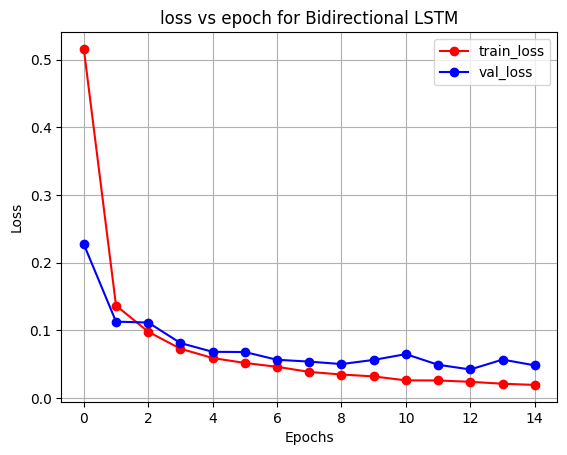

In [ ]:
plt.plot(range(15),train_loss,c="r",marker="o",label="train_loss")
plt.plot(range(15),val_loss,c="b",marker="o",label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("loss vs epoch for Bidirectional LSTM")
plt.grid(True)
plt.legend()
plt.show()

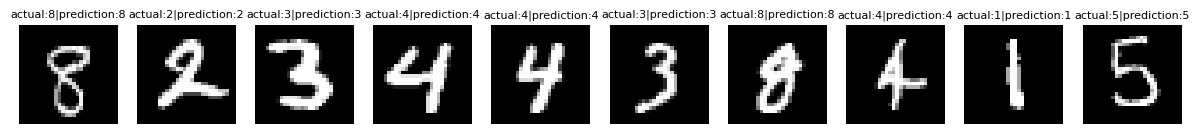

In [ ]:
plot_image(lstm_bi)

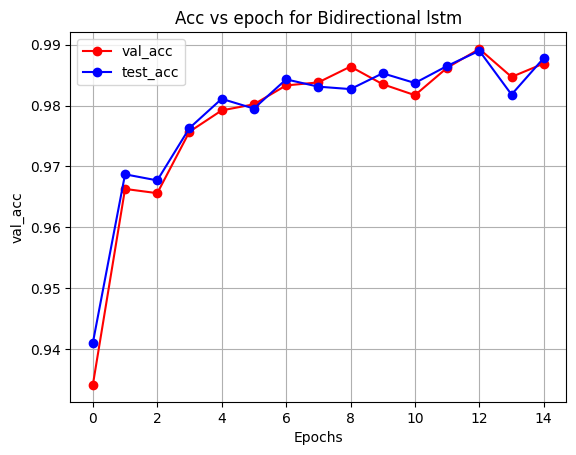

In [ ]:
plt.plot(range(15),val_acc,c="r",marker="o",label="val_acc")
plt.plot(range(15),test_acc,c="b",marker="o",label="test_acc")
plt.xlabel("Epochs")
plt.ylabel("val_acc")
plt.title("Acc vs epoch for Bidirectional lstm")
plt.grid(True)
plt.legend()
plt.show()

GRU wit hidden_size=64

In [9]:
input_size=28
sequence_length=28
num_layers=2
hidden_size=64
num_classes=10
num_epochs=15
batch_size=64
lr=1e-3

In [13]:
gru_64=RNN(input_size,hidden_size,num_layers,num_classes,"GRU").to(device)
optimizer=torch.optim.Adam(gru_64.parameters(),lr=1e-3)
train_loss,val_loss,val_acc,test_acc=train(gru_64,num_epochs,train_loader,val_loader,optimizer,criterion)

Epoch [1/15], train_loss: 0.5887 , val_loss: 0.1832 , val_acc: 0.9487 , test_acc: 0.9447
Epoch [2/15], train_loss: 0.1470 , val_loss: 0.1133 , val_acc: 0.9672 , test_acc: 0.9675
Epoch [3/15], train_loss: 0.0990 , val_loss: 0.0893 , val_acc: 0.9741 , test_acc: 0.9772
Epoch [4/15], train_loss: 0.0743 , val_loss: 0.0786 , val_acc: 0.9776 , test_acc: 0.9796
Epoch [5/15], train_loss: 0.0599 , val_loss: 0.0647 , val_acc: 0.9809 , test_acc: 0.9809
Epoch [6/15], train_loss: 0.0497 , val_loss: 0.0620 , val_acc: 0.9836 , test_acc: 0.9837
Epoch [7/15], train_loss: 0.0436 , val_loss: 0.0585 , val_acc: 0.9838 , test_acc: 0.9846
Epoch [8/15], train_loss: 0.0368 , val_loss: 0.0596 , val_acc: 0.9842 , test_acc: 0.9853
Epoch [9/15], train_loss: 0.0317 , val_loss: 0.0716 , val_acc: 0.9803 , test_acc: 0.9822
Epoch [10/15], train_loss: 0.0286 , val_loss: 0.0539 , val_acc: 0.9856 , test_acc: 0.9864
Epoch [11/15], train_loss: 0.0250 , val_loss: 0.0568 , val_acc: 0.9863 , test_acc: 0.9882
Epoch [12/15], trai

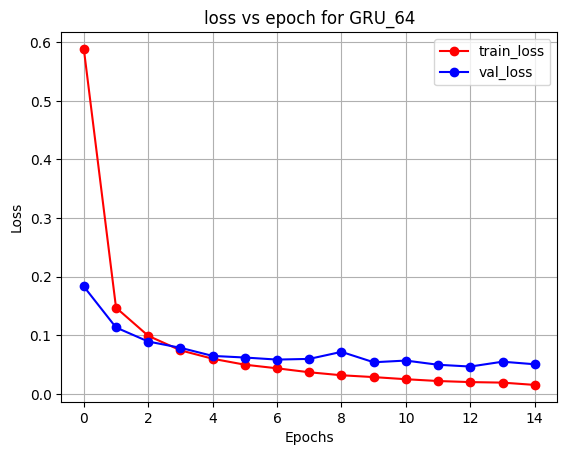

In [16]:
plt.plot(range(15),train_loss,c="r",marker="o",label="train_loss")
plt.plot(range(15),val_loss,c="b",marker="o",label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("loss vs epoch for GRU_64")
plt.grid(True)
plt.legend()
plt.show()

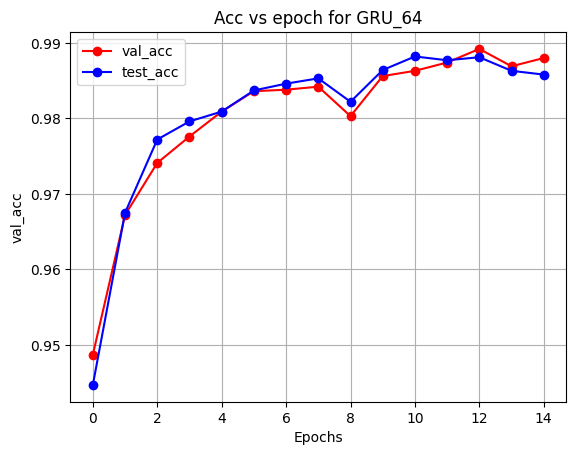

In [17]:
plt.plot(range(15),val_acc,c="r",marker="o",label="val_acc")
plt.plot(range(15),test_acc,c="b",marker="o",label="test_acc")
plt.xlabel("Epochs")
plt.ylabel("val_acc")
plt.title("Acc vs epoch for GRU_64")
plt.grid(True)
plt.legend()
plt.show()

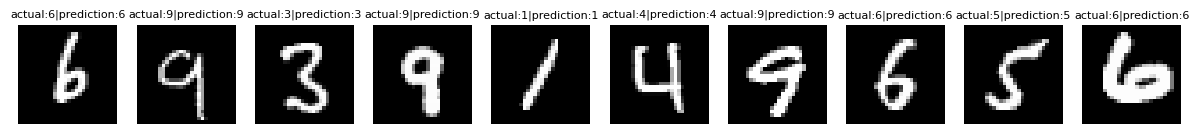

In [18]:
plot_image(gru_64)

GRU with hdden_size = 256

In [19]:
input_size=28
sequence_length=28
num_layers=2
hidden_size=256
num_classes=10
num_epochs=15
batch_size=64
lr=1e-3

In [20]:
gru_256=RNN(input_size,hidden_size,num_layers,num_classes,"GRU").to(device)
optimizer=torch.optim.Adam(gru_256.parameters(),lr=1e-3)
train_loss,val_loss,val_acc,test_acc=train(gru_256,num_epochs,train_loader,val_loader,optimizer,criterion)

Epoch [1/15], train_loss: 0.3580 , val_loss: 0.1061 , val_acc: 0.9688 , test_acc: 0.9710
Epoch [2/15], train_loss: 0.0851 , val_loss: 0.0829 , val_acc: 0.9763 , test_acc: 0.9783
Epoch [3/15], train_loss: 0.0517 , val_loss: 0.0511 , val_acc: 0.9869 , test_acc: 0.9863
Epoch [4/15], train_loss: 0.0405 , val_loss: 0.0415 , val_acc: 0.9885 , test_acc: 0.9880
Epoch [5/15], train_loss: 0.0337 , val_loss: 0.0470 , val_acc: 0.9870 , test_acc: 0.9856
Epoch [6/15], train_loss: 0.0303 , val_loss: 0.0393 , val_acc: 0.9893 , test_acc: 0.9873
Epoch [7/15], train_loss: 0.0212 , val_loss: 0.0450 , val_acc: 0.9886 , test_acc: 0.9912
Epoch [8/15], train_loss: 0.0194 , val_loss: 0.0539 , val_acc: 0.9862 , test_acc: 0.9874
Epoch [9/15], train_loss: 0.0192 , val_loss: 0.0468 , val_acc: 0.9882 , test_acc: 0.9889
Epoch [10/15], train_loss: 0.0162 , val_loss: 0.0472 , val_acc: 0.9902 , test_acc: 0.9904
Epoch [11/15], train_loss: 0.0139 , val_loss: 0.0595 , val_acc: 0.9843 , test_acc: 0.9852
Epoch [12/15], trai

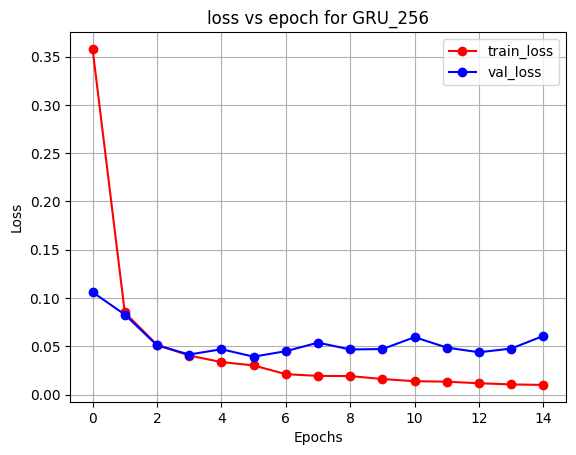

In [22]:
plt.plot(range(15),train_loss,c="r",marker="o",label="train_loss")
plt.plot(range(15),val_loss,c="b",marker="o",label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("loss vs epoch for GRU_256")
plt.grid(True)
plt.legend()
plt.show()

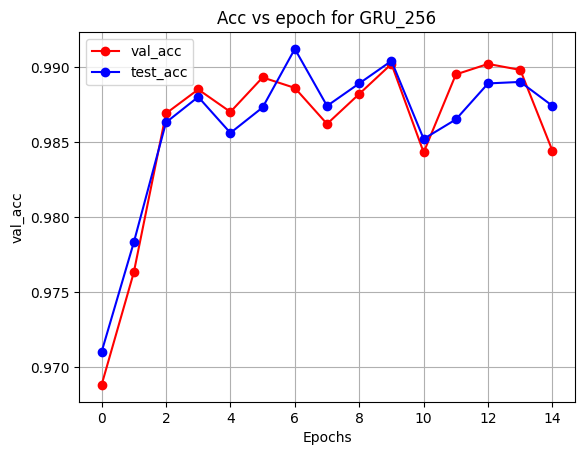

In [24]:
plt.plot(range(15),val_acc,c="r",marker="o",label="val_acc")
plt.plot(range(15),test_acc,c="b",marker="o",label="test_acc")
plt.xlabel("Epochs")
plt.ylabel("val_acc")
plt.title("Acc vs epoch for GRU_256")
plt.grid(True)
plt.legend()
plt.show()

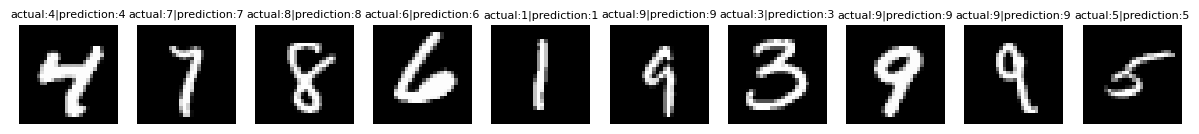

In [23]:
plot_image(gru_256)

Prediction for hand written digits

In [ ]:

import torch
from PIL import Image
import torchvision.transforms as transforms

def conversion_img_tensor(imag_path):
  image = Image.open(imag_path)
  transform = transforms.Compose([
      transforms.PILToTensor()
  ])
  img_tensor = transform(image)/255
  img_tensor = (img_tensor[0]+img_tensor[1]+img_tensor[2])/3
  return img_tensor


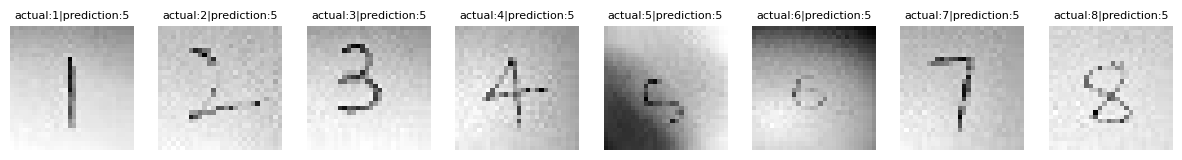

In [ ]:
gru.eval()
plt.figure(figsize=(15, 4))
index=1
with torch.no_grad():
  for i in range(1,9):
    original_img=conversion_img_tensor("image_" +str(i) + ".jpeg")
    ax=plt.subplot(2,8,index)
    model_img=original_img.reshape(1,28,28).to(device)
    label=i
    predicted=gru(model_img)
    predicted=torch.argmax(predicted,1).to("cpu").item()
    plt.imshow(original_img,cmap="gray")
    ax.set_title(f"actual:{label}|prediction:{predicted}",size=8)
    ax.axis("off")
    index+=1

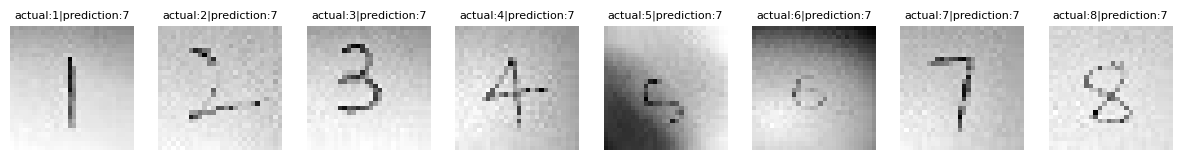

In [ ]:
vanilla_rnn.eval()
plt.figure(figsize=(15, 4))
index=1
with torch.no_grad():
  for i in range(1,9):
    original_img=conversion_img_tensor("image_" +str(i) + ".jpeg")
    ax=plt.subplot(2,8,index)
    model_img=original_img.reshape(1,28,28).to(device)
    label=i
    predicted=vanilla_rnn(model_img)
    predicted=torch.argmax(predicted,1).to("cpu").item()
    plt.imshow(original_img,cmap="gray")
    ax.set_title(f"actual:{label}|prediction:{predicted}",size=8)
    ax.axis("off")
    index+=1

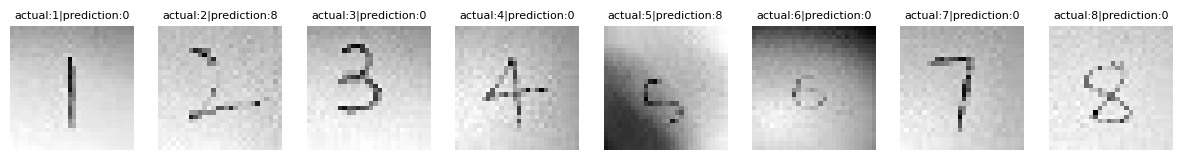

In [ ]:
lstm.eval()
plt.figure(figsize=(15, 4))
index=1
with torch.no_grad():
  for i in range(1,9):
    original_img=conversion_img_tensor("image_" +str(i) + ".jpeg")
    ax=plt.subplot(2,8,index)
    model_img=original_img.reshape(1,28,28).to(device)
    label=i
    predicted=lstm(model_img)
    predicted=torch.argmax(predicted,1).to("cpu").item()
    plt.imshow(original_img,cmap="gray")
    ax.set_title(f"actual:{label}|prediction:{predicted}",size=8)
    ax.axis("off")
    index+=1

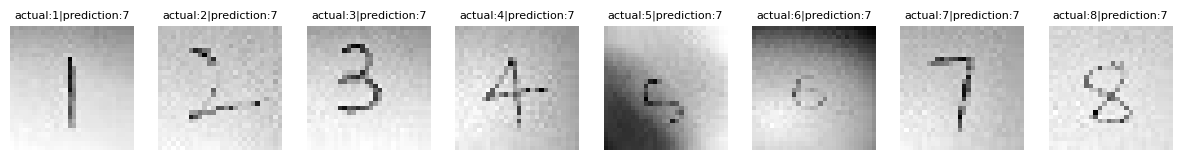

In [ ]:
vanilla_rnn.eval()
plt.figure(figsize=(15, 4))
index=1
with torch.no_grad():
  for i in range(1,9):
    original_img=conversion_img_tensor("image_" +str(i) + ".jpeg")
    ax=plt.subplot(2,8,index)
    model_img=original_img.reshape(1,28,28).to(device)
    label=i
    predicted=vanilla_rnn(model_img)
    predicted=torch.argmax(predicted,1).to("cpu").item()
    plt.imshow(original_img,cmap="gray")
    ax.set_title(f"actual:{label}|prediction:{predicted}",size=8)
    ax.axis("off")
    index+=1

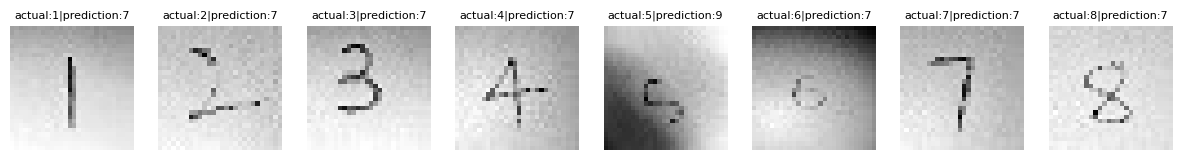

In [ ]:
lstm_bi.eval()
plt.figure(figsize=(15, 4))
index=1
with torch.no_grad():
  for i in range(1,9):
    original_img=conversion_img_tensor("image_" +str(i) + ".jpeg")
    ax=plt.subplot(2,8,index)
    model_img=original_img.reshape(1,28,28).to(device)
    label=i
    predicted=lstm_bi(model_img)
    predicted=torch.argmax(predicted,1).to("cpu").item()
    plt.imshow(original_img,cmap="gray")
    ax.set_title(f"actual:{label}|prediction:{predicted}",size=8)
    ax.axis("off")
    index+=1

2 ADDING TWO BINARY STRINGS

In [ ]:
def create_data_batch(batch_size,L):
  seq_len=L+1
  i1=np.random.randint(0,2,size=(batch_size,L))
  i2=np.random.randint(0,2,size=(batch_size,L))
  i1_padded=np.hstack((i1,np.zeros((batch_size,1))))
  i2_padded=np.hstack((i2,np.zeros((batch_size,1))))
  pow2=2**np.arange(L)
  i1_d=i1@pow2
  i2_d=i2@pow2
  sum_d=i1_d+i2_d
  sum_bits=np.zeros((batch_size,seq_len))
  shifters=np.arange(seq_len).reshape(1,-1)
  sum_bits=(sum_d.reshape(-1,1) >> shifters) & 1
  input_data=np.stack([i1_padded,i2_padded],axis=2)
  inputs_tensor = torch.tensor(input_data, dtype=torch.float32)
  targets_tensor = torch.tensor(sum_bits, dtype=torch.float32).unsqueeze(-1)
  return inputs_tensor, targets_tensor

array([[0, 1, 2, 3, 4]])

In [ ]:
create_data_batch(10,2)

(tensor([[[1., 0.],
          [0., 1.],
          [0., 0.]],
 
         [[1., 0.],
          [1., 0.],
          [0., 0.]],
 
         [[1., 1.],
          [0., 1.],
          [0., 0.]],
 
         [[0., 0.],
          [0., 0.],
          [0., 0.]],
 
         [[0., 0.],
          [1., 0.],
          [0., 0.]],
 
         [[1., 1.],
          [0., 0.],
          [0., 0.]],
 
         [[1., 1.],
          [1., 1.],
          [0., 0.]],
 
         [[0., 1.],
          [0., 1.],
          [0., 0.]],
 
         [[0., 1.],
          [0., 0.],
          [0., 0.]],
 
         [[0., 0.],
          [1., 1.],
          [0., 0.]]]),
 tensor([[[1.],
          [1.],
          [0.]],
 
         [[1.],
          [1.],
          [0.]],
 
         [[0.],
          [0.],
          [1.]],
 
         [[0.],
          [0.],
          [0.]],
 
         [[0.],
          [1.],
          [0.]],
 
         [[0.],
          [1.],
          [0.]],
 
         [[0.],
          [1.],
          [1.]],
 
         [[1.

In [ ]:
class Binary_adder(nn.Module):
  def __init__(self,input_size,hidden_size,num_layers):
    super().__init__()
    self.lstm=nn.LSTM(input_size,hidden_size,num_layers,batch_first=True)
    self.fc=nn.Linear(hidden_size,1)
    self.sigmoid=nn.Sigmoid()

  def forward(self,x):
    out,_=self.lstm(x)
    out=self.fc(out)
    return self.sigmoid(out)

In [ ]:
def training_loop(model,epochs,optimizer,criterion,batch_size,l_train,l_test):
  train_loss=[]
  test_loss=[]
  for epoch in range(epochs):
    model.train()
    inputs,targets=create_data_batch(batch_size,l_train)
    inputs=inputs.to(device)
    targets=targets.to(device)
    outputs=model(inputs)
    loss=criterion(outputs,targets)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_loss.append(loss.item())
    model.eval()
    with torch.no_grad():
      test_inputs,test_targets=create_data_batch(batch_size,l_test)
      test_inputs=test_inputs.to(device)
      test_targets=test_targets.to(device)
      test_outputs=model(test_inputs)
      test_loss.append(criterion(test_outputs,test_targets).item())
    if (epoch) % 50 == 0:
        print(f'Epoch [{epoch}/{epoch}], Train Loss: {train_loss[-1]:.4f}, Test Loss: {test_loss[-1]:.4f}')
  return train_loss,test_loss

In [ ]:
def plot_loss(train_loss,test_loss,hidden_size,l_train,l_test,loss_type):
  plt.figure(figsize=(10, 5))
  plt.plot(train_loss, label='Training Loss',marker="o")
  plt.plot(test_loss, label='Test (Validation) Loss')
  plt.title(f'Loss vs. Epochs (H={hidden_size}, L_train={l_train}, L_test={l_test}, Loss={loss_type})')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid(True)
  plt.show()

In [ ]:
def avg_bit_accuracy(model,hidden_size,l_train,l_test,batch_size=100):
  avg_bit_acc=[]
  sum_acc=0
  for i in range(1,21):
    model.eval()
    with torch.no_grad():
      test_inputs,test_targets=create_data_batch(batch_size,i)
      test_inputs=test_inputs.to(device)
      test_targets=test_targets.to(device)
      test_outputs=model(test_inputs)
      predicted_bits=(test_outputs > 0.5).float()
      acc=(predicted_bits==test_targets).float().mean().item()
      sum_acc+=acc
      avg_bit_acc.append(acc)
  plt.figure(figsize=(10, 5))
  plt.plot(range(1,21),avg_bit_acc,label="acc",marker="o",linestyle="-")
  plt.title(f"Avg-bit-acc vs Input length(L) for hidden_size={hidden_size}, l_train={l_train}, l_test={l_test}")
  plt.xlabel("Input length(L)")
  plt.ylabel("Avg-bit-acc")
  plt.ylim(-0.05, 1.05)
  plt.grid(True)
  plt.legend()
  plt.show()
  return sum_acc/20

MODEL_0:

In [ ]:
input_size=2
hidden_size=5
num_layers=1
l_train=5
l_test=5
epochs=100000
batch_size=128
lr=1e-4

In [ ]:
model=Binary_adder(input_size,hidden_size,num_layers).to(device)
criterion=nn.BCELoss()
optimizer=torch.optim.Adam(model.parameters(),lr=lr)

In [ ]:
train_loss,test_loss=training_loop(model,epochs,optimizer,criterion,batch_size,l_train,l_test)

Epoch [0/0], Train Loss: 0.1954, Test Loss: 0.1966
Epoch [50/50], Train Loss: 0.2040, Test Loss: 0.1932
Epoch [100/100], Train Loss: 0.2036, Test Loss: 0.1874
Epoch [150/150], Train Loss: 0.2067, Test Loss: 0.2127
Epoch [200/200], Train Loss: 0.2170, Test Loss: 0.2114
Epoch [250/250], Train Loss: 0.1985, Test Loss: 0.2003
Epoch [300/300], Train Loss: 0.2037, Test Loss: 0.2111
Epoch [350/350], Train Loss: 0.1813, Test Loss: 0.1874
Epoch [400/400], Train Loss: 0.1780, Test Loss: 0.1966
Epoch [450/450], Train Loss: 0.2033, Test Loss: 0.1880
Epoch [500/500], Train Loss: 0.2030, Test Loss: 0.2015
Epoch [550/550], Train Loss: 0.2028, Test Loss: 0.1968
Epoch [600/600], Train Loss: 0.2004, Test Loss: 0.1924
Epoch [650/650], Train Loss: 0.1969, Test Loss: 0.1883
Epoch [700/700], Train Loss: 0.1679, Test Loss: 0.1805
Epoch [750/750], Train Loss: 0.1721, Test Loss: 0.1874
Epoch [800/800], Train Loss: 0.1861, Test Loss: 0.1862
Epoch [850/850], Train Loss: 0.1928, Test Loss: 0.1773
Epoch [900/900],

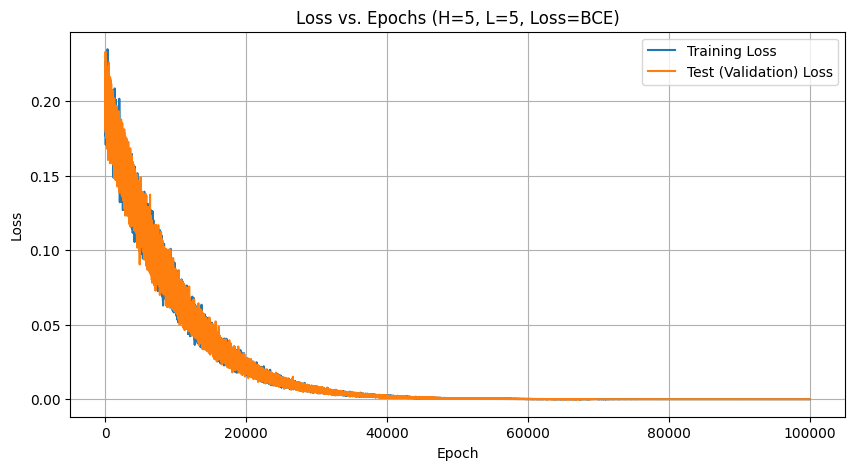

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss')
plt.plot(test_loss, label='Test (Validation) Loss')
plt.title(f'Loss vs. Epochs (H={hidden_size}, L={l_train}, Loss=BCE)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
x,y=create_data_batch(1,10)
y_1=model(x)
print(y_1)
print(y)

tensor([[[1.0000e+00],
         [1.0000e+00],
         [1.6658e-08],
         [4.4280e-09],
         [7.3997e-08],
         [2.4249e-08],
         [1.3330e-06],
         [9.9998e-01],
         [9.9998e-01],
         [8.8674e-05],
         [1.0000e+00]]], grad_fn=<SigmoidBackward0>)
tensor([[[1.],
         [1.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [1.],
         [1.],
         [0.],
         [1.]]])


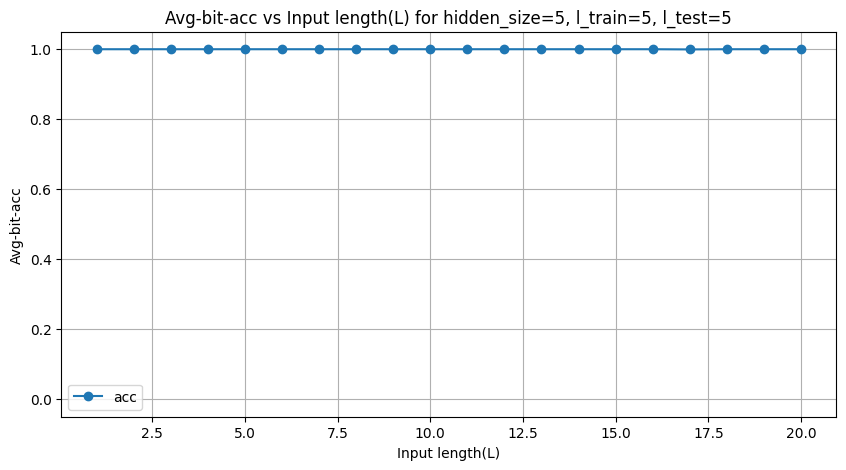

0.9999722212553024

In [ ]:
avg_bit_accuracy(model,5,5,5,100)

MODEL_1:

In [ ]:
input_size=2
hidden_size=5
num_layers=1
l_train=5
l_test=5
epochs=50000
batch_size=128
lr=1e-4
loss_type="MSE"

In [ ]:
model_1=Binary_adder(input_size,hidden_size,num_layers).to(device)
criterion=nn.MSELoss()
optimizer=torch.optim.Adam(model_1.parameters(),lr=lr)

In [ ]:
train_loss,test_loss=training_loop(model_1,epochs,optimizer,criterion,batch_size,l_train,l_test)

Epoch [0/0], Train Loss: 0.2526, Test Loss: 0.2588
Epoch [50/50], Train Loss: 0.2527, Test Loss: 0.2544
Epoch [100/100], Train Loss: 0.2492, Test Loss: 0.2537
Epoch [150/150], Train Loss: 0.2542, Test Loss: 0.2546
Epoch [200/200], Train Loss: 0.2544, Test Loss: 0.2548
Epoch [250/250], Train Loss: 0.2533, Test Loss: 0.2490
Epoch [300/300], Train Loss: 0.2540, Test Loss: 0.2539
Epoch [350/350], Train Loss: 0.2497, Test Loss: 0.2530
Epoch [400/400], Train Loss: 0.2510, Test Loss: 0.2472
Epoch [450/450], Train Loss: 0.2499, Test Loss: 0.2507
Epoch [500/500], Train Loss: 0.2522, Test Loss: 0.2514
Epoch [550/550], Train Loss: 0.2518, Test Loss: 0.2523
Epoch [600/600], Train Loss: 0.2507, Test Loss: 0.2475
Epoch [650/650], Train Loss: 0.2498, Test Loss: 0.2485
Epoch [700/700], Train Loss: 0.2492, Test Loss: 0.2491
Epoch [750/750], Train Loss: 0.2512, Test Loss: 0.2482
Epoch [800/800], Train Loss: 0.2519, Test Loss: 0.2508
Epoch [850/850], Train Loss: 0.2500, Test Loss: 0.2508
Epoch [900/900],

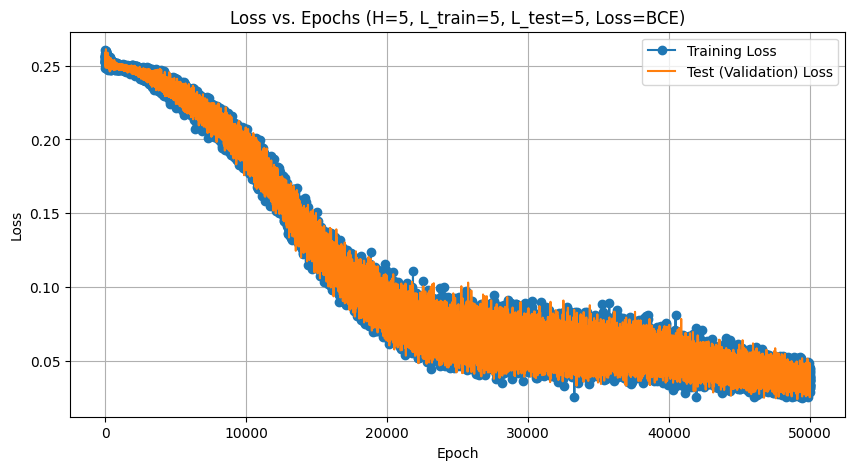

In [ ]:
plot_loss(train_loss,test_loss,hidden_size,l_train,l_test,loss_type)

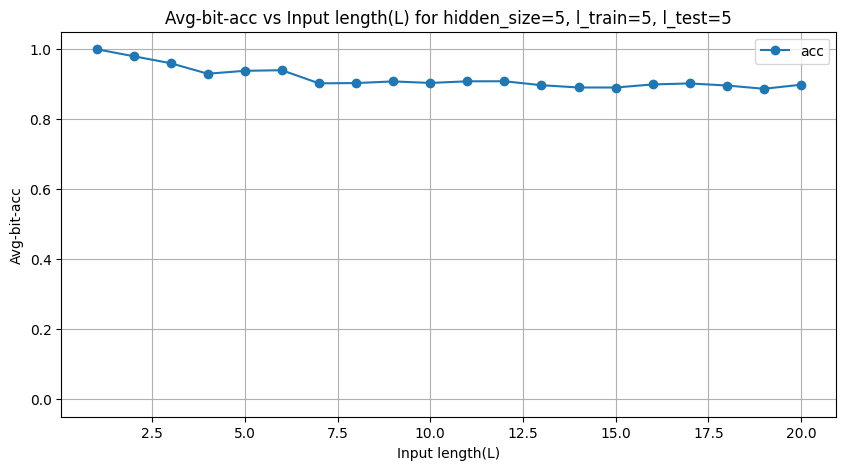

0.9172276765108108

In [ ]:
avg_bit_accuracy(model_1,hidden_size,l_train,l_test,batch_size=100)

MODEL_2:

In [ ]:
input_size=2
hidden_size=10
num_layers=1
l_train=5
l_test=5
epochs=50000
batch_size=128
lr=1e-4
loss_type="BCE"

In [ ]:
model_2=Binary_adder(input_size,hidden_size,num_layers).to(device)
criterion=nn.BCELoss()
optimizer=torch.optim.Adam(model_2.parameters(),lr=lr)

In [ ]:
train_loss,test_loss=training_loop(model_2,epochs,optimizer,criterion,batch_size,l_train,l_test)

Epoch [0/0], Train Loss: 0.6919, Test Loss: 0.6933
Epoch [50/50], Train Loss: 0.6923, Test Loss: 0.6929
Epoch [100/100], Train Loss: 0.6926, Test Loss: 0.6929
Epoch [150/150], Train Loss: 0.6933, Test Loss: 0.6929
Epoch [200/200], Train Loss: 0.6928, Test Loss: 0.6934
Epoch [250/250], Train Loss: 0.6925, Test Loss: 0.6921
Epoch [300/300], Train Loss: 0.6928, Test Loss: 0.6930
Epoch [350/350], Train Loss: 0.6916, Test Loss: 0.6914
Epoch [400/400], Train Loss: 0.6928, Test Loss: 0.6926
Epoch [450/450], Train Loss: 0.6921, Test Loss: 0.6923
Epoch [500/500], Train Loss: 0.6917, Test Loss: 0.6920
Epoch [550/550], Train Loss: 0.6921, Test Loss: 0.6920
Epoch [600/600], Train Loss: 0.6925, Test Loss: 0.6917
Epoch [650/650], Train Loss: 0.6920, Test Loss: 0.6924
Epoch [700/700], Train Loss: 0.6920, Test Loss: 0.6920
Epoch [750/750], Train Loss: 0.6916, Test Loss: 0.6923
Epoch [800/800], Train Loss: 0.6926, Test Loss: 0.6904
Epoch [850/850], Train Loss: 0.6909, Test Loss: 0.6922
Epoch [900/900],

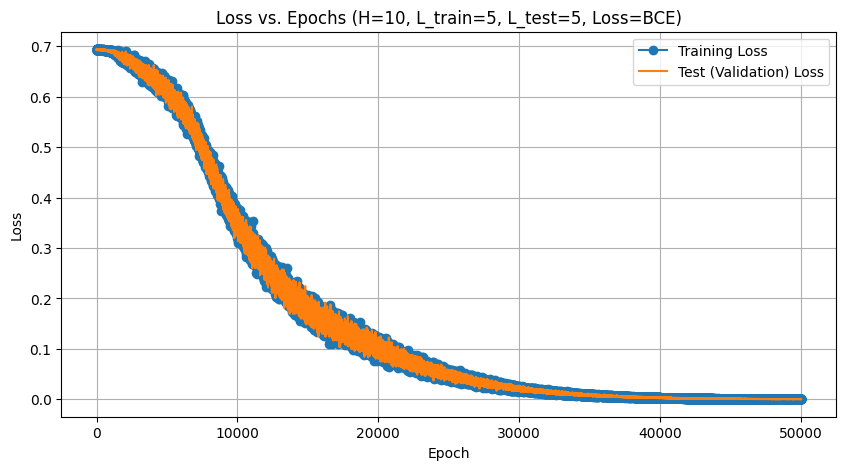

In [ ]:
plot_loss(train_loss,test_loss,hidden_size,l_train,l_test,loss_type)

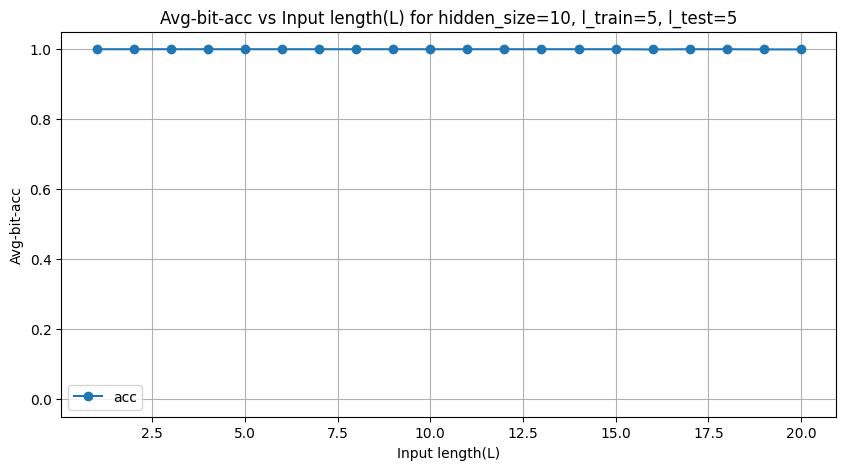

0.999921777844429

In [ ]:
avg_bit_accuracy(model_2,hidden_size,l_train,l_test,batch_size=100)

Model_3:

In [ ]:
input_size=2
hidden_size=10
num_layers=1
l_train=5
l_test=5
epochs=37000
batch_size=128
lr=1e-4
loss_type="MSE"

In [ ]:
model_3=Binary_adder(input_size,hidden_size,num_layers).to(device)
criterion=nn.MSELoss()
optimizer=torch.optim.Adam(model_3.parameters(),lr=lr)

In [ ]:
train_loss,test_loss=training_loop(model_3,epochs,optimizer,criterion,batch_size,l_train,l_test)

Epoch [0/0], Train Loss: 0.2496, Test Loss: 0.2501
Epoch [50/50], Train Loss: 0.2498, Test Loss: 0.2502
Epoch [100/100], Train Loss: 0.2501, Test Loss: 0.2500
Epoch [150/150], Train Loss: 0.2501, Test Loss: 0.2500
Epoch [200/200], Train Loss: 0.2500, Test Loss: 0.2496
Epoch [250/250], Train Loss: 0.2494, Test Loss: 0.2498
Epoch [300/300], Train Loss: 0.2498, Test Loss: 0.2499
Epoch [350/350], Train Loss: 0.2495, Test Loss: 0.2495
Epoch [400/400], Train Loss: 0.2494, Test Loss: 0.2490
Epoch [450/450], Train Loss: 0.2496, Test Loss: 0.2488
Epoch [500/500], Train Loss: 0.2496, Test Loss: 0.2491
Epoch [550/550], Train Loss: 0.2490, Test Loss: 0.2497
Epoch [600/600], Train Loss: 0.2493, Test Loss: 0.2494
Epoch [650/650], Train Loss: 0.2490, Test Loss: 0.2492
Epoch [700/700], Train Loss: 0.2487, Test Loss: 0.2490
Epoch [750/750], Train Loss: 0.2479, Test Loss: 0.2496
Epoch [800/800], Train Loss: 0.2487, Test Loss: 0.2493
Epoch [850/850], Train Loss: 0.2494, Test Loss: 0.2479
Epoch [900/900],

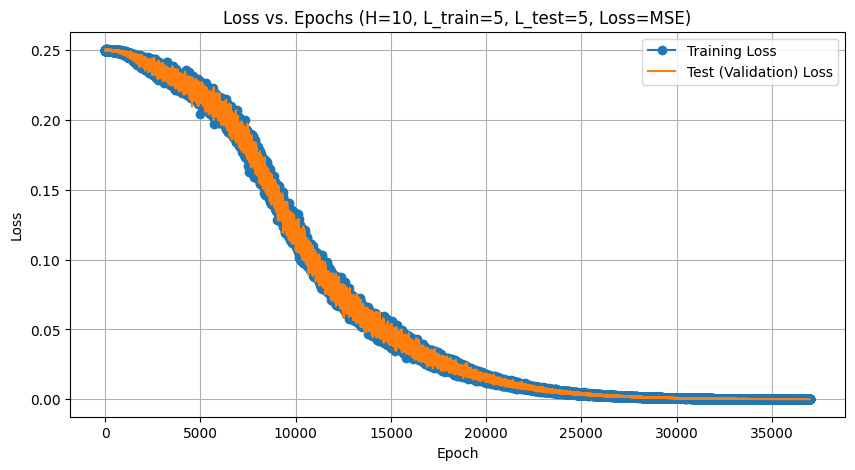

In [ ]:
plot_loss(train_loss,test_loss,hidden_size,l_train,l_test,loss_type)

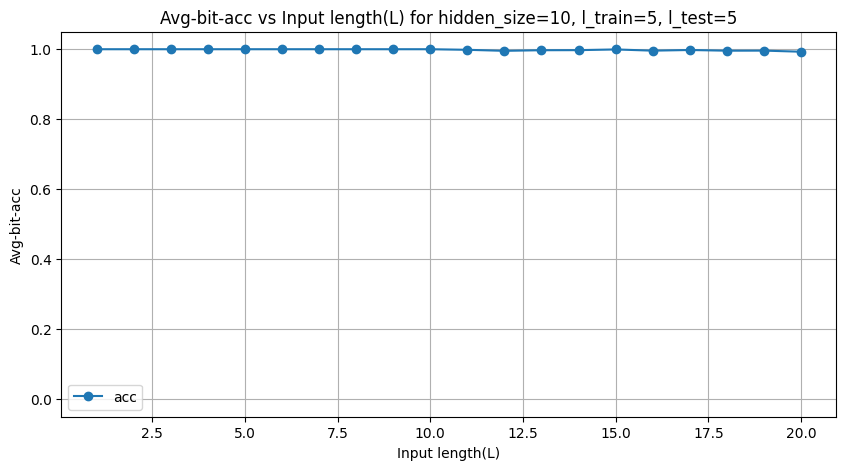

0.9982937932014465

In [ ]:
avg_bit_accuracy(model_3,hidden_size,l_train,l_test,batch_size=100)

Model_4:

In [ ]:
input_size=2
hidden_size=100
num_layers=1
l_train=5
l_test=5
epochs=22000
batch_size=128
lr=1e-4
loss_type="BCE"

In [ ]:
model_4=Binary_adder(input_size,hidden_size,num_layers).to(device)
criterion=nn.BCELoss()
optimizer=torch.optim.Adam(model_4.parameters(),lr=lr)

In [ ]:
train_loss,test_loss=training_loop(model_4,epochs,optimizer,criterion,batch_size,l_train,l_test)

Epoch [0/0], Train Loss: 0.6925, Test Loss: 0.6932
Epoch [50/50], Train Loss: 0.6931, Test Loss: 0.6933
Epoch [100/100], Train Loss: 0.6925, Test Loss: 0.6920
Epoch [150/150], Train Loss: 0.6915, Test Loss: 0.6913
Epoch [200/200], Train Loss: 0.6897, Test Loss: 0.6913
Epoch [250/250], Train Loss: 0.6873, Test Loss: 0.6880
Epoch [300/300], Train Loss: 0.6896, Test Loss: 0.6856
Epoch [350/350], Train Loss: 0.6859, Test Loss: 0.6812
Epoch [400/400], Train Loss: 0.6777, Test Loss: 0.6772
Epoch [450/450], Train Loss: 0.6779, Test Loss: 0.6703
Epoch [500/500], Train Loss: 0.6629, Test Loss: 0.6704
Epoch [550/550], Train Loss: 0.6611, Test Loss: 0.6613
Epoch [600/600], Train Loss: 0.6643, Test Loss: 0.6687
Epoch [650/650], Train Loss: 0.6599, Test Loss: 0.6617
Epoch [700/700], Train Loss: 0.6592, Test Loss: 0.6642
Epoch [750/750], Train Loss: 0.6636, Test Loss: 0.6687
Epoch [800/800], Train Loss: 0.6534, Test Loss: 0.6579
Epoch [850/850], Train Loss: 0.6576, Test Loss: 0.6570
Epoch [900/900],

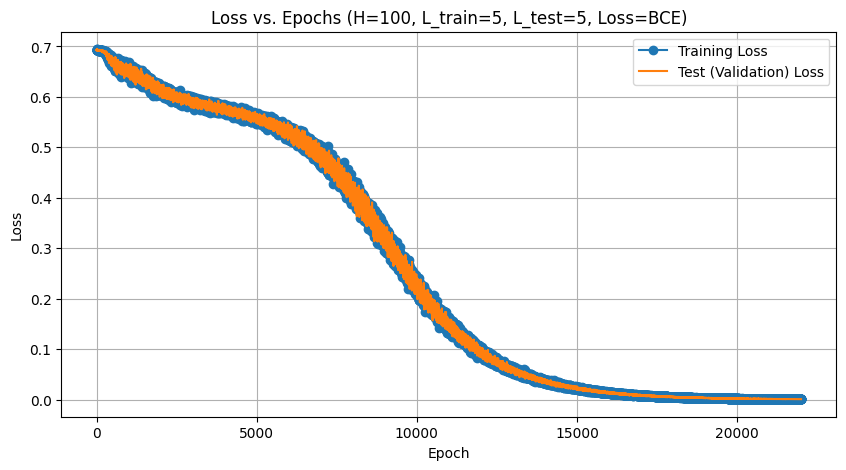

In [ ]:
plot_loss(train_loss,test_loss,hidden_size,l_train,l_test,loss_type)

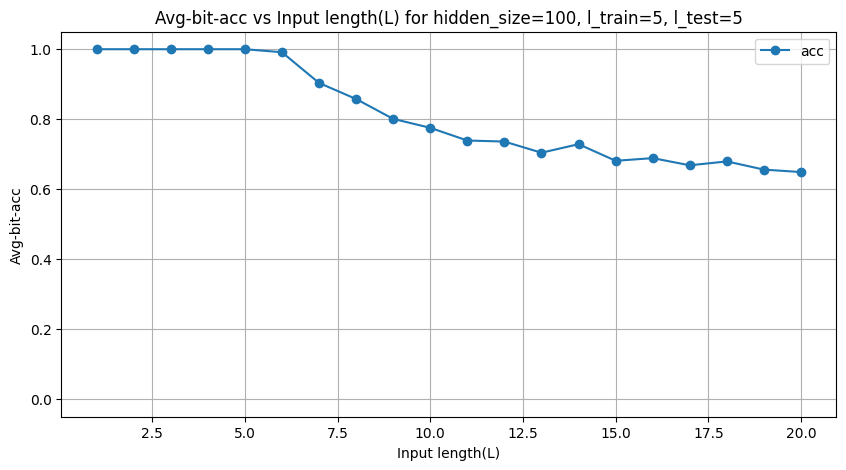

0.8130305975675582

In [ ]:
avg_bit_accuracy(model_4,hidden_size,l_train,l_test,batch_size=100)

model_5:

In [ ]:
input_size=2
hidden_size=100
num_layers=1
l_train=5
l_test=5
epochs=20000
batch_size=128
lr=1e-4
loss_type="MSE"

In [ ]:
model_5=Binary_adder(input_size,hidden_size,num_layers).to(device)
criterion=nn.MSELoss()
optimizer=torch.optim.Adam(model_5.parameters(),lr=lr)

In [ ]:
train_loss,test_loss=training_loop(model_5,epochs,optimizer,criterion,batch_size,l_train,l_test)

Epoch [0/0], Train Loss: 0.2499, Test Loss: 0.2497
Epoch [50/50], Train Loss: 0.2494, Test Loss: 0.2498
Epoch [100/100], Train Loss: 0.2490, Test Loss: 0.2493
Epoch [150/150], Train Loss: 0.2493, Test Loss: 0.2490
Epoch [200/200], Train Loss: 0.2482, Test Loss: 0.2481
Epoch [250/250], Train Loss: 0.2476, Test Loss: 0.2471
Epoch [300/300], Train Loss: 0.2457, Test Loss: 0.2454
Epoch [350/350], Train Loss: 0.2446, Test Loss: 0.2440
Epoch [400/400], Train Loss: 0.2417, Test Loss: 0.2439
Epoch [450/450], Train Loss: 0.2407, Test Loss: 0.2407
Epoch [500/500], Train Loss: 0.2399, Test Loss: 0.2386
Epoch [550/550], Train Loss: 0.2365, Test Loss: 0.2352
Epoch [600/600], Train Loss: 0.2393, Test Loss: 0.2361
Epoch [650/650], Train Loss: 0.2346, Test Loss: 0.2327
Epoch [700/700], Train Loss: 0.2334, Test Loss: 0.2299
Epoch [750/750], Train Loss: 0.2351, Test Loss: 0.2300
Epoch [800/800], Train Loss: 0.2344, Test Loss: 0.2365
Epoch [850/850], Train Loss: 0.2298, Test Loss: 0.2342
Epoch [900/900],

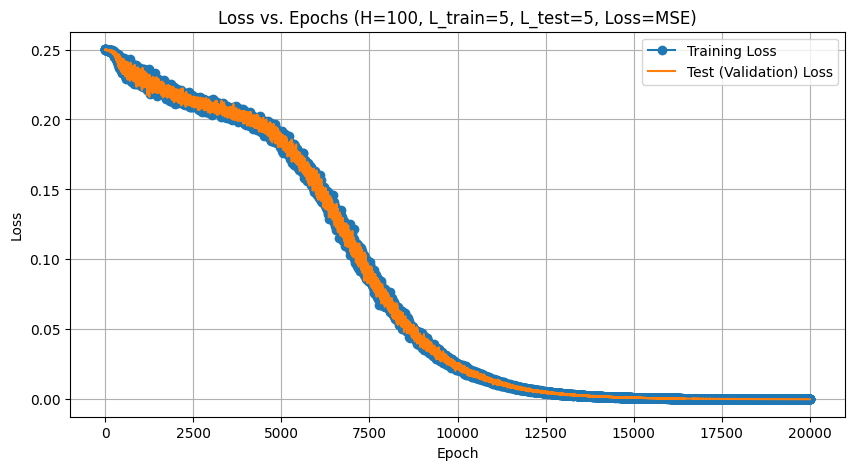

In [ ]:
plot_loss(train_loss,test_loss,hidden_size,l_train,l_test,loss_type)

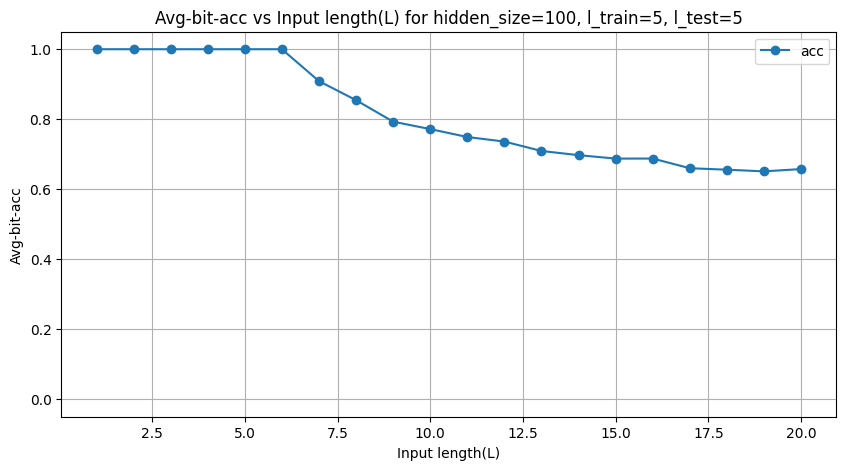

0.8109753906726838

In [ ]:
avg_bit_accuracy(model_5,hidden_size,l_train,l_test,batch_size=100)

model_6

In [ ]:
input_size=2
hidden_size=10
num_layers=1
l_train=3
l_test=5
epochs=50000
batch_size=128
lr=1e-4
loss_type="BCE"

In [ ]:
model_6=Binary_adder(input_size,hidden_size,num_layers).to(device)
criterion=nn.BCELoss()
optimizer=torch.optim.Adam(model_6.parameters(),lr=lr)

In [ ]:
train_loss,test_loss=training_loop(model_6,epochs,optimizer,criterion,batch_size,l_train,l_test)

Epoch [0/0], Train Loss: 0.7185, Test Loss: 0.7140
Epoch [50/50], Train Loss: 0.7131, Test Loss: 0.7011
Epoch [100/100], Train Loss: 0.7108, Test Loss: 0.7081
Epoch [150/150], Train Loss: 0.7062, Test Loss: 0.7045
Epoch [200/200], Train Loss: 0.7069, Test Loss: 0.6939
Epoch [250/250], Train Loss: 0.7101, Test Loss: 0.6978
Epoch [300/300], Train Loss: 0.7094, Test Loss: 0.7017
Epoch [350/350], Train Loss: 0.7063, Test Loss: 0.6946
Epoch [400/400], Train Loss: 0.7085, Test Loss: 0.6969
Epoch [450/450], Train Loss: 0.7057, Test Loss: 0.6995
Epoch [500/500], Train Loss: 0.7006, Test Loss: 0.6973
Epoch [550/550], Train Loss: 0.6991, Test Loss: 0.6942
Epoch [600/600], Train Loss: 0.7016, Test Loss: 0.6950
Epoch [650/650], Train Loss: 0.6935, Test Loss: 0.6963
Epoch [700/700], Train Loss: 0.6944, Test Loss: 0.6943
Epoch [750/750], Train Loss: 0.6906, Test Loss: 0.6923
Epoch [800/800], Train Loss: 0.6964, Test Loss: 0.6935
Epoch [850/850], Train Loss: 0.6942, Test Loss: 0.6941
Epoch [900/900],

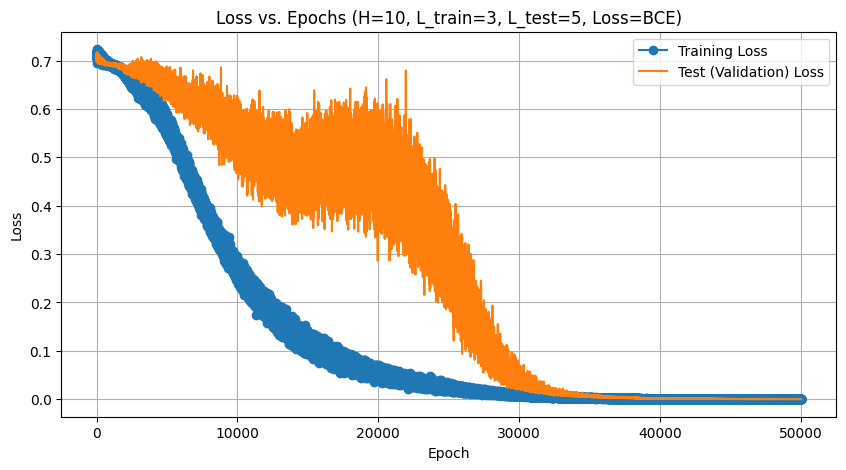

In [ ]:
plot_loss(train_loss,test_loss,hidden_size,l_train,l_test,loss_type)

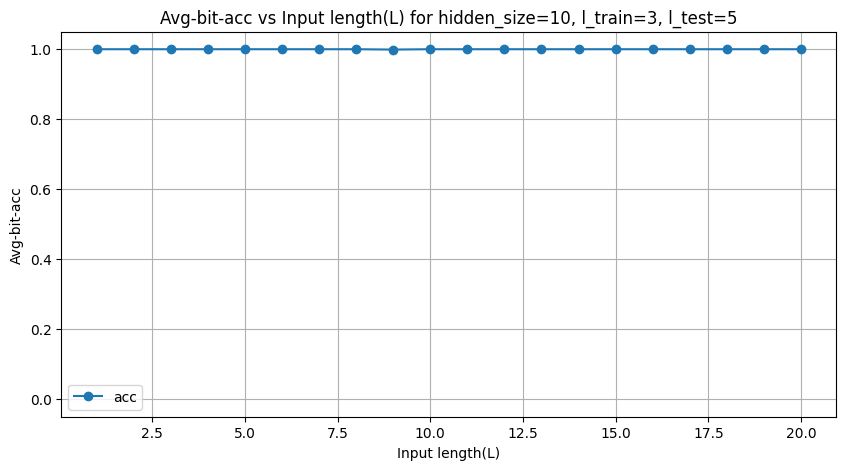

0.9999500006437302

In [ ]:
avg_bit_accuracy(model_6,hidden_size,l_train,l_test,batch_size=100)

model_7

In [ ]:
input_size=2
hidden_size=10
num_layers=1
l_train=10
l_test=5
epochs=50000
batch_size=128
lr=1e-4
loss_type="BCE"

In [ ]:
model_7=Binary_adder(input_size,hidden_size,num_layers).to(device)
criterion=nn.BCELoss()
optimizer=torch.optim.Adam(model_7.parameters(),lr=lr)

In [ ]:
train_loss,test_loss=training_loop(model_7,epochs,optimizer,criterion,batch_size,l_train,l_test)

Epoch [0/0], Train Loss: 0.7078, Test Loss: 0.7055
Epoch [50/50], Train Loss: 0.7035, Test Loss: 0.7094
Epoch [100/100], Train Loss: 0.6934, Test Loss: 0.6872
Epoch [150/150], Train Loss: 0.6993, Test Loss: 0.6987
Epoch [200/200], Train Loss: 0.6985, Test Loss: 0.6986
Epoch [250/250], Train Loss: 0.6974, Test Loss: 0.6948
Epoch [300/300], Train Loss: 0.6963, Test Loss: 0.6952
Epoch [350/350], Train Loss: 0.6942, Test Loss: 0.6943
Epoch [400/400], Train Loss: 0.6922, Test Loss: 0.6931
Epoch [450/450], Train Loss: 0.6949, Test Loss: 0.6928
Epoch [500/500], Train Loss: 0.6956, Test Loss: 0.6937
Epoch [550/550], Train Loss: 0.6933, Test Loss: 0.6953
Epoch [600/600], Train Loss: 0.6935, Test Loss: 0.6932
Epoch [650/650], Train Loss: 0.6934, Test Loss: 0.6931
Epoch [700/700], Train Loss: 0.6922, Test Loss: 0.6944
Epoch [750/750], Train Loss: 0.6924, Test Loss: 0.6931
Epoch [800/800], Train Loss: 0.6931, Test Loss: 0.6920
Epoch [850/850], Train Loss: 0.6925, Test Loss: 0.6921
Epoch [900/900],

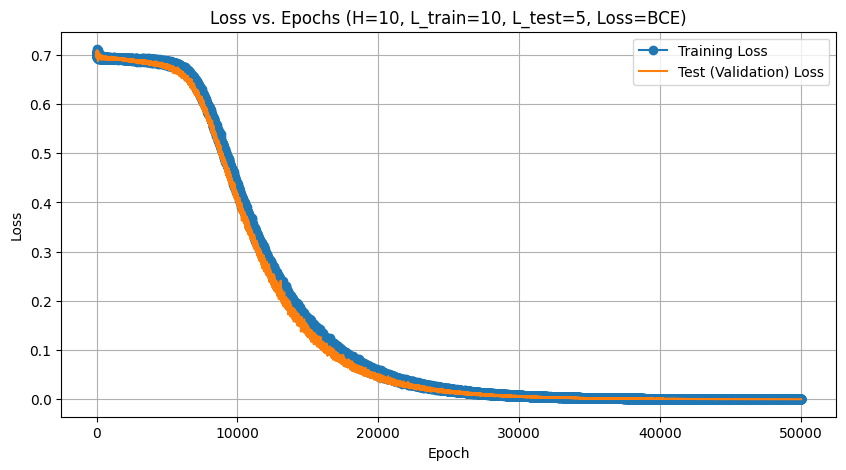

In [ ]:
plot_loss(train_loss,test_loss,hidden_size,l_train,l_test,loss_type)

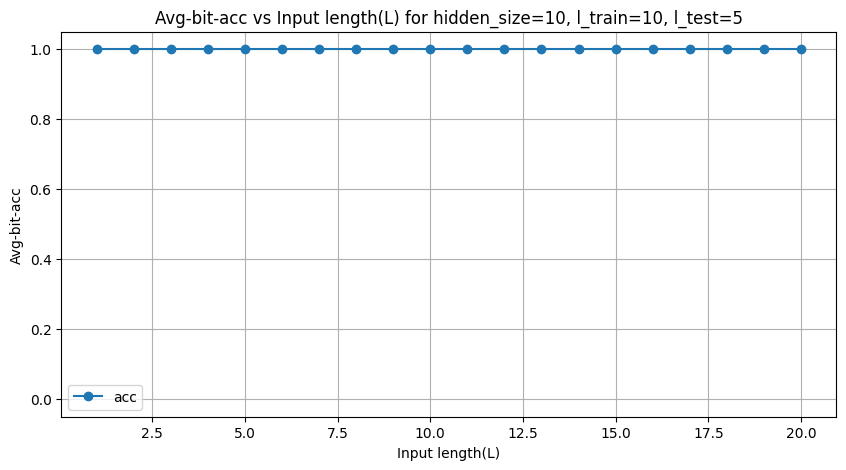

1.0

In [ ]:
avg_bit_accuracy(model_7,hidden_size,l_train,l_test,batch_size=100)